In [1]:
import numpy as np
import matplotlib.pyplot as plt
from classy import Class
from scipy.special import spherical_jn as jn
from scipy.integrate import simps
from scipy.interpolate import interp1d

dat1 = np.genfromtxt('../data/dNdzs/LRGz1_dNdz.txt')
dat2 = np.genfromtxt('../data/dNdzs/LRGz2_dNdz.txt')
dat3 = np.genfromtxt('../data/dNdzs/LRGz3_dNdz.txt')
dat4 = np.genfromtxt('../data/dNdzs/LRGz4_dNdz.txt')
bias = interp1d([0.47,0.62,0.78,0.91],[1.63,1.88,2.08,2.20],kind='linear',fill_value="extrapolate")

def do_integrals(z_, dNdz, bias, lval=np.arange(0,130,step=20), NCHI=5000, NK=5000, 
                 NKint=1000,kmin=1e-3,kmax=0.5,only_limb=False,DBeff=False):
    """
    computes limber and beyond limber integrals for Cgg and Ckg
    assuming linear theory
    """
    params = {'output': 'mPk lCl','P_k_max_h/Mpc': 20.,
              'z_pk': '0.0,10','A_s': 2.150860e-9,'n_s': 0.9625356,
              'alpha_s': 0.,'h': 0.6702393, 'N_ur': 1.0196,
              'N_ncdm': 2,'m_ncdm': '0.01,0.05','tau_reio': 0.0568,
              'omega_b': 0.02219218,'omega_cdm': 0.1203058,'Omega_k': 0.}
    
    cosmo = Class()
    cosmo.set(params)
    cosmo.compute()
    
    z   = np.linspace(1e-3,max(z_)*1.2,NCHI)
    chi = np.vectorize(cosmo.comoving_distance)(z)*cosmo.h()
    
    # set up the kernels
    Wg  = interp1d(z_,dNdz,kind='cubic',bounds_error=False,fill_value=0)(z)
    Wg /= simps(Wg,x=chi)
    dWg = np.gradient(Wg,chi)
    ddWg = np.gradient(dWg,chi)
    zstar   = cosmo.get_current_derived_parameters(['z_rec'])['z_rec']
    chistar = cosmo.comoving_distance(zstar)*cosmo.h()
    Wk  = 1.5*cosmo.Om_m(0)*(1/2997.92458)**2*(1+z)*chi*(chistar-chi)/chistar
    D = np.vectorize(cosmo.scale_independent_growth_factor)(z)
    f = np.vectorize(cosmo.scale_independent_growth_factor_f)(z)
    b = bias(z)
    
    k   = np.logspace(np.log10(kmin),np.log10(kmax),NK)
    kint= np.logspace(np.log10(kmin),np.log10(kmax),NKint)
    Pk  = np.array([cosmo.pk(kk*cosmo.h(),0) for kk in k])*cosmo.h()**3

    zeff = simps(z*Wg**2/chi**2,x=chi)/simps(Wg**2/chi**2,x=chi)
    print(f'zeff = {zeff:0.02f}')
    
    Wreal = lambda l,k: simps(4*np.pi*Wg*jn(l,k*chi)*D*b,x=chi)
    Wrsd  = lambda l,k: simps(4*np.pi*dWg*jn(l,k*chi,derivative=True)*D*f,x=chi)/k
    Wkap  = lambda l,k: simps(4*np.pi*Wk*jn(l,k*chi)*D,x=chi)
    
    def Cgg_full(l):
        Ireal = interp1d(kint,[Wreal(l,kk) for kk in kint],kind='cubic')(k)
        Irsd  = interp1d(kint,[Wrsd(l,kk)  for kk in kint],kind='cubic')(k)
        integrand = k**2 * Pk * (Ireal + Irsd)**2 / (2*np.pi)**3
        return simps(integrand,x=k)
    
    def Ckg_full(l):
        Ireal = interp1d(kint,[Wreal(l,kk) for kk in kint],kind='cubic')(k)
        Irsd  = interp1d(kint,[Wrsd(l,kk)  for kk in kint],kind='cubic')(k)
        Ikap  = interp1d(kint,[Wkap(l,kk)  for kk in kint],kind='cubic')(k)
        integrand = k**2 * Pk * Ikap * (Ireal+Irsd) / (2*np.pi)**3
        return simps(integrand,x=k)
    
    def Cgg_limber(l,DBeff=DBeff):
        kv = (l+0.5)/chi
        if DBeff:
            Deff = cosmo.scale_independent_growth_factor(zeff)
            Beff = bias(zeff)
        else:
            Deff = D
            Beff = b
        Pint = interp1d(k,Pk,bounds_error=False,fill_value=0.)(kv) * (Deff*Beff)**2
        integrand = Wg**2/chi**2 * Pint
        return simps(integrand,x=chi)
    
    def Ckg_limber(l,DBeff=DBeff):
        kv = (l+0.5)/chi
        if DBeff:
            Deff = cosmo.scale_independent_growth_factor(zeff)
            Beff = bias(zeff)
        else:
            Deff = D
            Beff = b
        Pint = interp1d(k,Pk,bounds_error=False,fill_value=0.)(kv) * Deff**2 * Beff
        integrand = Wg*Wk/chi**2 * Pint
        return simps(integrand,x=chi)

    l = np.arange(min(lval),max(lval))
    def dointrp(x): return interp1d(lval,x,kind='cubic')(l)
    cgg_limb = np.array([Cgg_limber(l) for l in lval])
    ckg_limb = np.array([Ckg_limber(l) for l in lval])
    if only_limb: return l, dointrp(cgg_limb), dointrp(ckg_limb)
    cgg_full = np.array([Cgg_full(l) for l in lval])
    ckg_full = np.array([Ckg_full(l) for l in lval])
    return l, dointrp(cgg_full), dointrp(cgg_limb), dointrp(ckg_full), dointrp(ckg_limb)

In [2]:
# make plots prettier
import matplotlib
from matplotlib.pyplot import rc
import matplotlib.font_manager

rc('font',**{'size':'22','family':'serif','serif':['CMU serif']})
rc('mathtext', **{'fontset':'cm'})
rc('text', usetex=True)
rc('legend',**{'fontsize':'18'})

matplotlib.rcParams['axes.linewidth'] = 3
matplotlib.rcParams['axes.labelsize'] = 30
matplotlib.rcParams['xtick.labelsize'] = 25 
matplotlib.rcParams['ytick.labelsize'] = 25
matplotlib.rcParams['legend.fontsize'] = 25
matplotlib.rcParams['xtick.major.size'] = 10
matplotlib.rcParams['ytick.major.size'] = 10
matplotlib.rcParams['xtick.minor.size'] = 5
matplotlib.rcParams['ytick.minor.size'] = 5
matplotlib.rcParams['xtick.major.width'] = 3
matplotlib.rcParams['ytick.major.width'] = 3
matplotlib.rcParams['xtick.minor.width'] = 1.5
matplotlib.rcParams['ytick.minor.width'] = 1.5
matplotlib.rcParams['axes.titlesize'] = 30
matplotlib.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

In [3]:
l, cgg_1f, cgg_1l, ckg_1f, ckg_1l = do_integrals(dat1[:,0],dat1[:,1],bias=bias)
l, cgg_2f, cgg_2l, ckg_2f, ckg_2l = do_integrals(dat2[:,0],dat2[:,1],bias=bias)
l, cgg_3f, cgg_3l, ckg_3f, ckg_3l = do_integrals(dat3[:,0],dat3[:,1],bias=bias)
l, cgg_4f, cgg_4l, ckg_4f, ckg_4l = do_integrals(dat4[:,0],dat4[:,1],bias=bias)

l, cgg_1l_zeff, ckg_1l_zeff = do_integrals(dat1[:,0],dat1[:,1],bias=bias,only_limb=True,DBeff=True)
l, cgg_2l_zeff, ckg_2l_zeff = do_integrals(dat2[:,0],dat2[:,1],bias=bias,only_limb=True,DBeff=True)
l, cgg_3l_zeff, ckg_3l_zeff = do_integrals(dat3[:,0],dat3[:,1],bias=bias,only_limb=True,DBeff=True)
l, cgg_4l_zeff, ckg_4l_zeff = do_integrals(dat4[:,0],dat4[:,1],bias=bias,only_limb=True,DBeff=True)

zeff = 0.47
zeff = 0.62
zeff = 0.78
zeff = 0.91
zeff = 0.47
zeff = 0.62
zeff = 0.78
zeff = 0.91


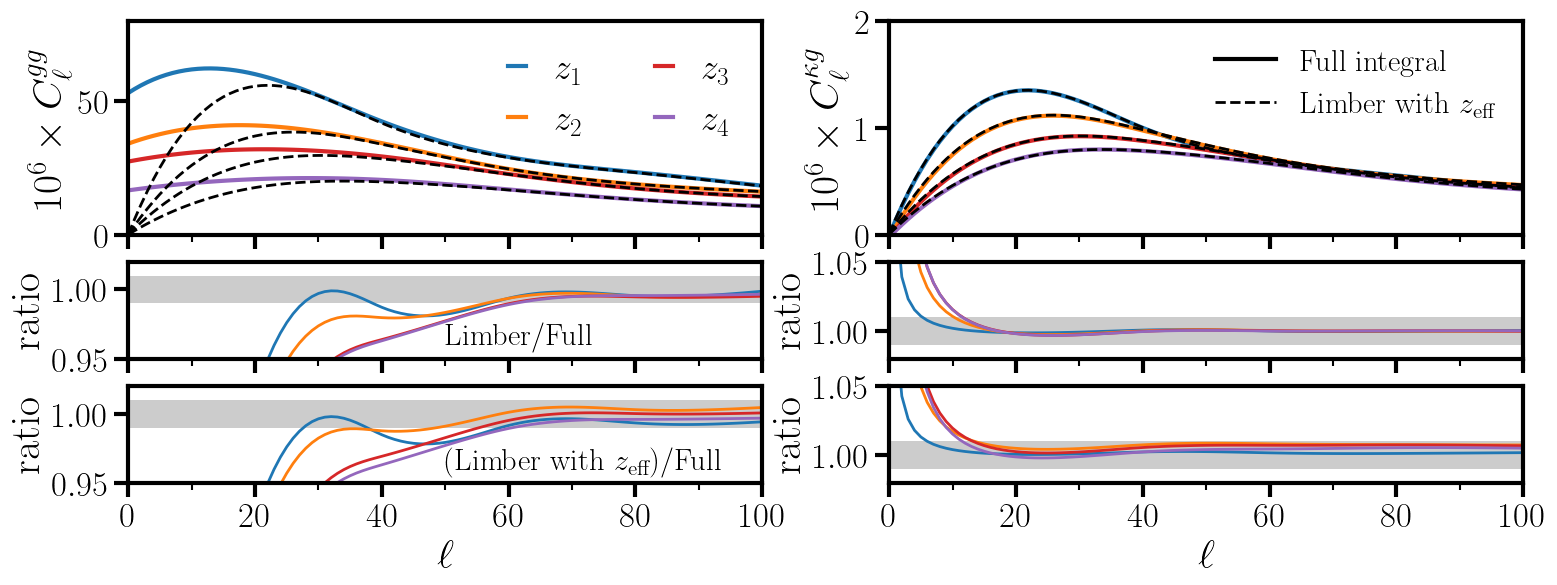

In [6]:
fig,ax = plt.subplots(3,2,figsize=(18,6),sharex=True,gridspec_kw={'height_ratios':[2.2,1,1],'hspace':0.2,'wspace':0.2})

# auto
ax[0,0].plot(l,1e6*cgg_1f,lw=3,c='C0',label=r'$z_1$')
ax[0,0].plot(l,1e6*cgg_2f,lw=3,c='C1',label=r'$z_2$')
ax[0,0].plot(l,1e6*cgg_3f,lw=3,c='C3',label=r'$z_3$')
ax[0,0].plot(l,1e6*cgg_4f,lw=3,c='C4',label=r'$z_4$')
ax[0,0].plot(l,1e6*cgg_1l_zeff,lw=2,c='k',ls='--')
ax[0,0].plot(l,1e6*cgg_2l_zeff,lw=2,c='k',ls='--') 
ax[0,0].plot(l,1e6*cgg_3l_zeff,lw=2,c='k',ls='--') 
ax[0,0].plot(l,1e6*cgg_4l_zeff,lw=2,c='k',ls='--') 
# ratios
# including redshift evolution
ax[1,0].plot(l,cgg_1l/cgg_1f,lw=2,c='C0',ls='-')
ax[1,0].plot(l,cgg_2l/cgg_2f,lw=2,c='C1',ls='-')
ax[1,0].plot(l,cgg_3l/cgg_3f,lw=2,c='C3',ls='-')
ax[1,0].plot(l,cgg_4l/cgg_4f,lw=2,c='C4',ls='-')
# effective redshift
ax[2,0].plot(l,cgg_1l_zeff/cgg_1f,lw=2,c='C0',ls='-')
ax[2,0].plot(l,cgg_2l_zeff/cgg_2f,lw=2,c='C1',ls='-')
ax[2,0].plot(l,cgg_3l_zeff/cgg_3f,lw=2,c='C3',ls='-')
ax[2,0].plot(l,cgg_4l_zeff/cgg_4f,lw=2,c='C4',ls='-')


# cross
ax[0,1].plot(l,1e6*ckg_1f,lw=3,c='C0')
ax[0,1].plot(l,1e6*ckg_2f,lw=3,c='C1')
ax[0,1].plot(l,1e6*ckg_3f,lw=3,c='C3')
ax[0,1].plot(l,1e6*ckg_4f,lw=3,c='C4')
ax[0,1].plot(l,1e6*ckg_1l_zeff,lw=2,c='k',ls='--')
ax[0,1].plot(l,1e6*ckg_2l_zeff,lw=2,c='k',ls='--') 
ax[0,1].plot(l,1e6*ckg_3l_zeff,lw=2,c='k',ls='--') 
ax[0,1].plot(l,1e6*ckg_4l_zeff,lw=2,c='k',ls='--') 
# ratios
# including redshift evolution
lmin = 1
ax[1,1].plot(l[lmin:],(ckg_1l/ckg_1f)[lmin:],lw=2,c='C0',ls='-')
ax[1,1].plot(l[lmin:],(ckg_2l/ckg_2f)[lmin:],lw=2,c='C1',ls='-')
ax[1,1].plot(l[lmin:],(ckg_3l/ckg_3f)[lmin:],lw=2,c='C3',ls='-')
ax[1,1].plot(l[lmin:],(ckg_4l/ckg_4f)[lmin:],lw=2,c='C4',ls='-')
# effective redshift
ax[2,1].plot(l[lmin:],(ckg_1l_zeff/ckg_1f)[lmin:],lw=2,c='C0',ls='-')
ax[2,1].plot(l[lmin:],(ckg_2l_zeff/ckg_2f)[lmin:],lw=2,c='C1',ls='-')
ax[2,1].plot(l[lmin:],(ckg_3l_zeff/ckg_3f)[lmin:],lw=2,c='C3',ls='-')
ax[2,1].plot(l[lmin:],(ckg_4l_zeff/ckg_4f)[lmin:],lw=2,c='C4',ls='-')


# for the legend
ax[0,1].plot([],[],lw=3,c='k',label=r'Full integral')
ax[0,1].plot([],[],lw=2,c='k',ls='--',label=r'Limber with $z_\text{eff}$')


ax[2,0].set_xticks([10*i for i in range(10)],minor=True)
ax[2,0].set_xlabel(r'$\ell$')
ax[2,1].set_xlabel(r'$\ell$')
ax[0,0].legend(loc='upper right',frameon=False,ncol=2,handlelength=0.5,fontsize=26)
ax[0,1].legend(loc='upper right',frameon=False,handlelength=2,fontsize=22)
ax[0,0].set_ylabel(r'$10^6\times C^{gg}_\ell$')
ax[0,1].set_ylabel(r'$10^6\times C^{\kappa g}_\ell$')
ax[1,0].set_ylabel(r'ratio')
ax[1,1].set_ylabel(r'ratio')
ax[2,0].set_ylabel(r'ratio')
ax[2,1].set_ylabel(r'ratio')
for i in range(2): 
    ax[1+i,0].set_ylim(0.95,1.02); ax[1+i,1].set_ylim(0.98,1.05)
    ax[1+i,0].fill_between([0,200],[0.99,0.99],[1.01,1.01],color='k',alpha=0.2,lw=0)
    ax[1+i,1].fill_between([0,200],[0.99,0.99],[1.01,1.01],color='k',alpha=0.2,lw=0)
ax[1,0].text(50,0.96,r'Limber/Full',fontsize=22)
ax[2,0].text(50,0.96,r'(Limber with $z_\text{eff}$)/Full',fontsize=22)
ax[0,0].set_xlim(0,100)
ax[0,0].set_ylim(0,80)
ax[0,1].set_ylim(0,2)
plt.savefig('../figures/beyondLimber.pdf',bbox_inches='tight')

In [21]:
# kg at ell = 75
print(f"Error for z1 = {((ckg_1l_zeff/ckg_1f)[75]-1)*100:0.2f}% at ell=75" )
print(f"Error for z1 = {((ckg_2l_zeff/ckg_2f)[75]-1)*100:0.2f}% at ell=75" )
print(f"Error for z1 = {((ckg_3l_zeff/ckg_3f)[75]-1)*100:0.2f}% at ell=75" )
print(f"Error for z1 = {((ckg_4l_zeff/ckg_4f)[75]-1)*100:0.2f}% at ell=75" )

Error for z1 = 0.13% at ell=75
Error for z1 = 0.78% at ell=75
Error for z1 = 0.74% at ell=75
Error for z1 = 0.52% at ell=75


In [22]:
# gg at ell = 75
print(f"Error for z1 = {((cgg_1l_zeff/cgg_1f)[75]-1)*100:0.2f}% at ell=75" )
print(f"Error for z1 = {((cgg_2l_zeff/cgg_2f)[75]-1)*100:0.2f}% at ell=75" )
print(f"Error for z1 = {((cgg_3l_zeff/cgg_3f)[75]-1)*100:0.2f}% at ell=75" )
print(f"Error for z1 = {((cgg_4l_zeff/cgg_4f)[75]-1)*100:0.2f}% at ell=75" )

Error for z1 = -0.48% at ell=75
Error for z1 = 0.41% at ell=75
Error for z1 = 0.06% at ell=75
Error for z1 = -0.42% at ell=75
